This notebook is meant to be an introduction to the stft which will be used in this project to extract features from music files. The stft is short for the Short Time Fourier Transform and creates spectograms for content whose frequencies vary throughout time (music being a perfect example). There are three tunable parameters: the size of the window, the amount of overlap between successive windows, and the size of the time windows with different frequencies. 

The size of the window has implication on the time precision and frequency resolution. Smaller windows allow for greater time precision, allowing for better observation amongst the transitions between different frequency content, but much lower frequency resolution. Frequency resolution refers to the size of the bins that frequency content gets placed into in a window. Choosing smaller windows is known as wideband and longer windows is known as narrowband. More details are shown in this image:

![NarrowbandVsWideband](./references/WidebandvsNarrowband.png)

This first example shows the results of using narrowband with a length of 20 samples per window:

![Narrowband](./references/NarrowBandSpectogram.png)

This next example shows the results of using wideband with a length of 10 samples per window:

![Wideband](./references/WideBandSpectogram.png)

Note that the terms narrowband and wideband are slighly objective, and I used them loosely to compare the two examples above. For further explanation, watch the following [video](https://www.youtube.com/watch?v=g1_wcbGUcDY).

The following is an example that generates an example of the dial buttons on a phone. The example is courteous of the video linked before, and the code is from the following [blog post](https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy
from IPython.display import Audio

In [2]:
def get_signal_Hz(Hz,sample_rate,length_ts_sec):
    ## 1 sec length time series with sampling rate 
    ts1sec = list(np.linspace(0,np.pi*2*Hz,sample_rate))
    ## 1 sec length time series with sampling rate 
    # multiplying a list by a constant appends constant copies to the list itself
    ts = ts1sec*length_ts_sec
    return(list(np.sin(ts)))

In [3]:
sample_rate   = 4000
length_ts_sec = 4
## --------------------------------- ##
## 3 seconds of "digit 1" sound
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1209Hz.
## --------------------------------- ##
ts1  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts1 += np.array(get_signal_Hz(1209,sample_rate,length_ts_sec))
ts1  = list(ts1)

## -------------------- ##
## 2 seconds of silence
## -------------------- ##
ts_silence = [0]*sample_rate*1

## --------------------------------- ##
## 3 seconds of "digit 2" sounds 
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1336Hz.
## --------------------------------- ##
ts2  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts2 += np.array(get_signal_Hz(1336,sample_rate,length_ts_sec))
ts2  = list(ts2)

## -------------------- ##
## Add up to 7 seconds
## ------------------- ##
# concatenates the lists, doesn't sum their values like a numpy array
ts = ts1 + ts_silence  + ts2

In [4]:
Audio(ts, rate=sample_rate)

The total time series length = 9.0 sec (N points = 36000) 


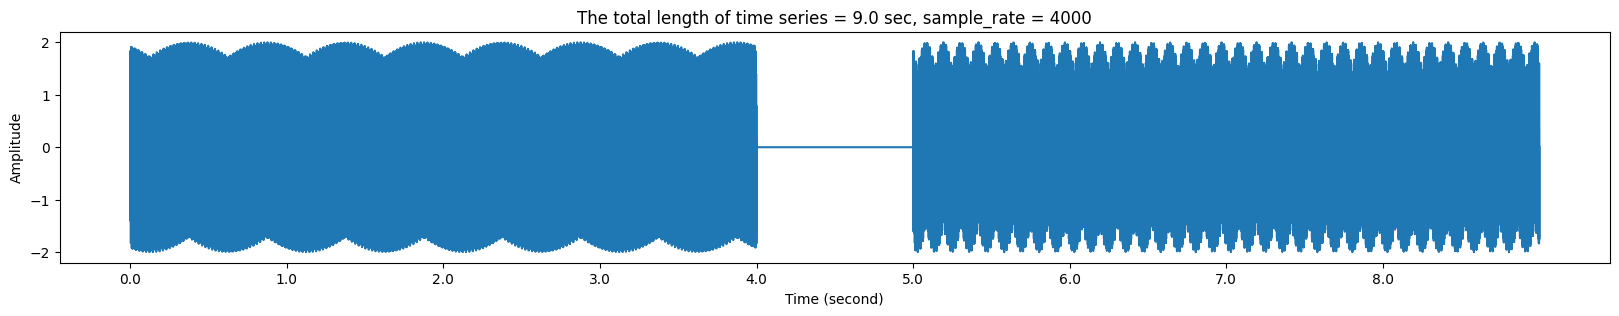

In [5]:
total_ts_sec = len(ts)/sample_rate
print("The total time series length = {} sec (N points = {}) ".format(total_ts_sec, len(ts)))
plt.figure(figsize=(20,3))
plt.plot(ts)
plt.xticks(np.arange(0,len(ts),sample_rate),
           np.arange(0,len(ts)/sample_rate,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (second)")
plt.title("The total length of time series = {} sec, sample_rate = {}".format(len(ts)/sample_rate, sample_rate))
plt.show()

In [6]:
def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )

def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L)) # /L
    # print("xn: {}, xn_abs: {}".format(xn, abs(xn)))
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)
def create_spectrogram(ts,NFFT,noverlap = None):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    # start: 0, stop: length of time series, step: NFFT - noverlap
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # print(starts)
    # remove any window with less than NFFT sample size
    # in other words, remove the last window if it contains more samples than the time series
    starts  = starts[starts + NFFT < len(ts)]
    # print(starts)
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    np.savetxt("OutputText/basic_dft_output.txt", np.array(xns), fmt="%.3f")
    # print(specX.T.shape)
    # print(specX.shape)
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(abs(specX))
    np.savetxt("OutputText/basic_dft_output.txt", spec, fmt="%.3f")
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(ts),Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)

The code below demonstrates a spectogram where the first three seconds shows the frequency content of the first button press, and the last three shows the frequency content of the second button press. As you can see, the middle second is just white since that's where there was silence. 

/tmp/ipykernel_3362/3921215883.py:55: RuntimeWarning: divide by zero encountered in log10
  spec = 10*np.log10(abs(specX))


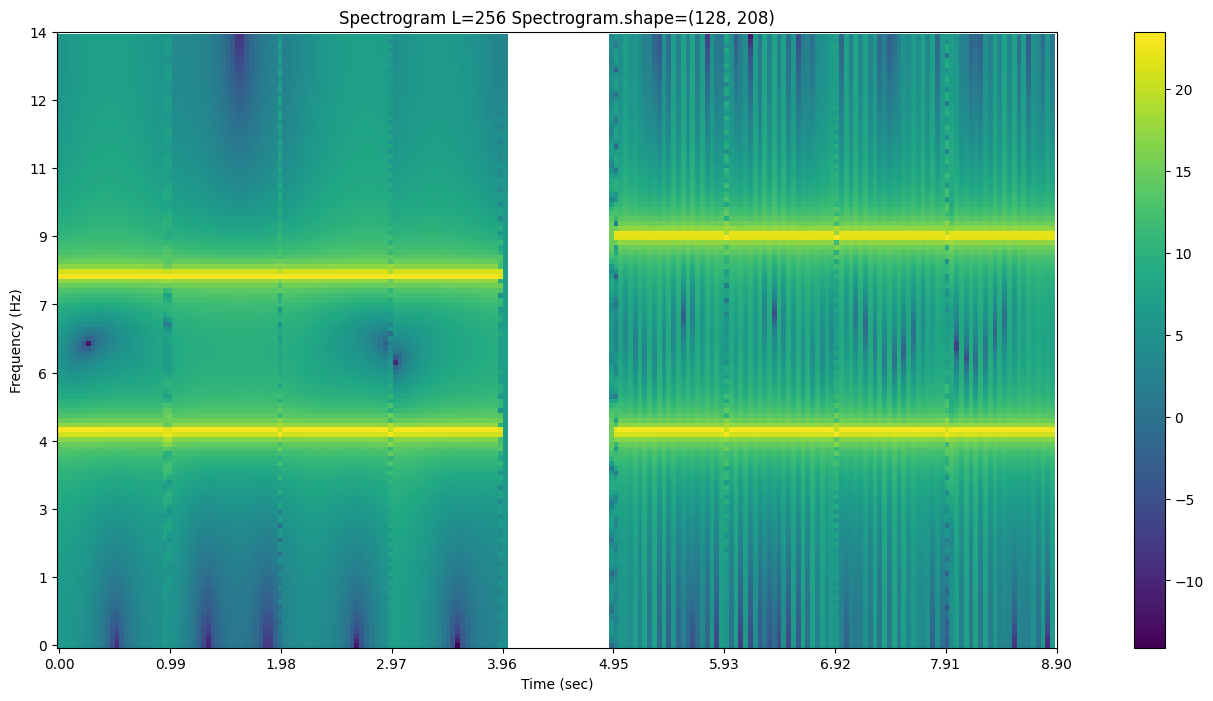

In [7]:
L = 256
noverlap = 84
mag = get_xns(ts)
Nxlim = 10
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(ts))
starts, spec = create_spectrogram(ts,L,noverlap = noverlap )
plot_spectrogram(spec,ks,sample_rate,L, starts)

In [8]:
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)
    
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    print(x.shape)
    # print(x)
    x = x.reshape((N_min, -1))
    print(x.shape)
    # print(x)
    X = np.dot(M, x)

    print("M: {}, x: {}, X:{}".format(M.shape, x.shape, X.shape))

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] // 2]
        X_odd = X[:, X.shape[1] // 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])
        print("New X.shape: {}".format(X.shape))

    print("X: {}".format(X.shape))

    return X.ravel()

In [9]:
x = np.random.random(128)
output_a = FFT(x)
output_b = FFT_vectorized(x)
print("Close: {}".format(np.allclose(output_a, output_b)))

(128,)
(32, 4)
M: (32, 32), x: (32, 4), X:(32, 4)
New X.shape: (64, 2)
New X.shape: (128, 1)
X: (128, 1)
Close: True


The Short Time Fourier Transform extracts meaningful features that can be used to train neural networks for music classification which is what I hope to do. Though there are Python libraries and even CUDA libraries that are capable of taking the STFT of signals, my goal was to perform this algorithm myself in CUDA in order to exploit the parallel components of the algorithm. Since I will be training a neural network with the [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset which contains 1,000 .wav files, taking the STFT of all these files will hopefully perform faster using CUDA. By using Pybind11, I have made it possible to import my CUDA STFT and FFT GPU code into python files.

NOTE: These functions must be called with a number of samples that are a power of 2, and at most 1,024 samples can be computed. This upper limit is because NVIDIA GPU's limit 1,024 threads per block. Since the radix-2 FFT algorithm requires a lot of data being shared amongst threads, shared memory provides a great advantage but only threads in the same block can shared their data. I have ideas on how to increase this limit in the future but it is not of great concern to me since for this project, I do not intend on using FFT's on more than 1,024 samples at a time. As of right now, I find taking FFT's on 256 samples at a time is ideal for mainting a well balanced spectogram in terms of time precision and frequency resolution.

cuFFT took 723.9761352539062 ms to finish
numpy's fft took 0.31495094299316406 ms to finish
Results match: True

len ts: 36000
result shape: (129, 280)
cuSTFT took 7.193088531494141 ms to finish
t shape: (280,)
t0: 0.032, t1: 0.064,  t[279]: 8.96
scipy's stft took 192.2314167022705 ms to finish


/tmp/ipykernel_3362/3051020951.py:33: RuntimeWarning: divide by zero encountered in log10
  scipy_result = 20*np.log10(scipy_result)


cuSTFT error: 0.0027685492801771874%


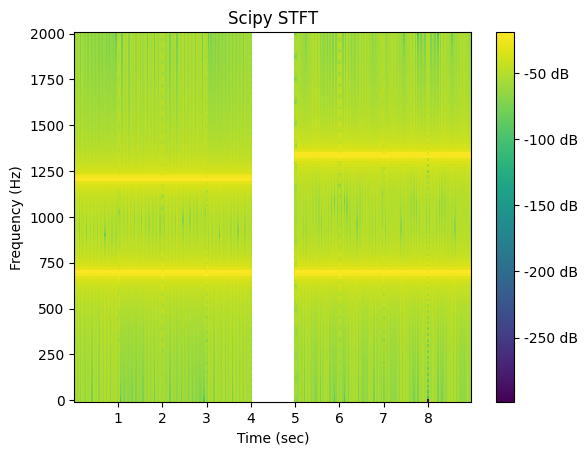

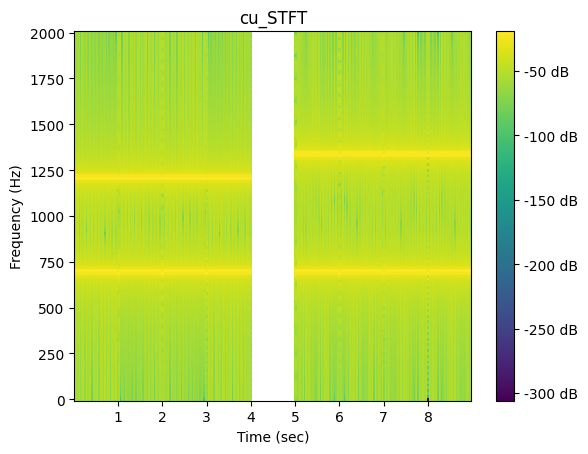

In [10]:
import build.pybind_modules.dsp_module as cu
from time import time

cu_start = time()
result = cu.cuFFT(list(ts[:1024]))
cu_end = time()
print("cuFFT took {} ms to finish".format((cu_end - cu_start)*1000))

np_start = time()
np_result = np.fft.fft(ts[:1024])
np_end = time()
print("numpy's fft took {} ms to finish".format((np_end - np_start)*1000))

results_close = np.allclose(result, np_result)
print("Results match: {}\n".format(results_close))

nfft = 256 
noverlap = -1
cu_start = time()
result = cu.cuSTFT(list(ts), sample_rate, nfft, noverlap, True, 0)
print("len ts: {}".format(len(ts)))
print("result shape: {}".format(result.shape))
cu_end = time()
print("cuSTFT took {} ms to finish".format((cu_end - cu_start)*1000))
scipy_start = time()
f, t, scipy_result = scipy.signal.stft(ts, fs=sample_rate, window="boxcar", nperseg=nfft, noverlap=None if noverlap == -1 else noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
print("t shape: {}".format(t.shape))
print("t0: {}, t1: {},  t[279]: {}".format(t[0],t[1], t[279]))
# convert to power spectral density
# since scipy_result is a complex spectrum, the equation to get PSD is 20*log10(abs(scipy_result))
# https://dsp.stackexchange.com/questions/54811/how-to-calculate-the-psd-from-the-complex-calculated-stft
scipy_result = np.abs(scipy_result)
scipy_result = 20*np.log10(scipy_result)
scipy_end = time()
print("scipy's stft took {} ms to finish".format((scipy_end - scipy_start)*1000))
# result = result[:,:-1] # my stft always takes one more time slice than scipy stft does

result_1D = result.ravel()
scipy_result_1D = scipy_result.ravel()

total = len(scipy_result_1D)
mismatches = 0
for i in range(len(scipy_result_1D)):
    if not np.isclose(scipy_result_1D[i], result_1D[i]):
        mismatches += 1

percent_error = (mismatches / total) * 100
print("cuSTFT error: {}%".format(percent_error))

plt.title("Scipy STFT")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, scipy_result)
plt.colorbar(format="%+2.f dB")
plt.show()

plt.title("cu_STFT")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, result)
plt.colorbar(format="%+2.f dB")
plt.show()

The results above show that my cuFFT GPU code matches the output of Numpy's FFT function. My cuSTFT GPU code closely matches the output of Scipy's STFT code with an error below 0.1% which is very insignificant for the 9 second sound. The graphs of the output from the two functions also show just how close the results are. Unfortunately I need to look further into optimizing the GPU code since it is algorithimically correct, but it slower than the serial STFT function by Scipy. 

/tmp/ipykernel_3362/1252349424.py:13: RuntimeWarning: divide by zero encountered in log10
  scipy_result_boxcar = 20*np.log10(scipy_result_boxcar)
/tmp/ipykernel_3362/1252349424.py:15: RuntimeWarning: divide by zero encountered in log10
  scipy_result_hamming = 20*np.log10(scipy_result_hamming)
/tmp/ipykernel_3362/1252349424.py:17: RuntimeWarning: divide by zero encountered in log10
  scipy_result_hanning = 20*np.log10(scipy_result_hanning)


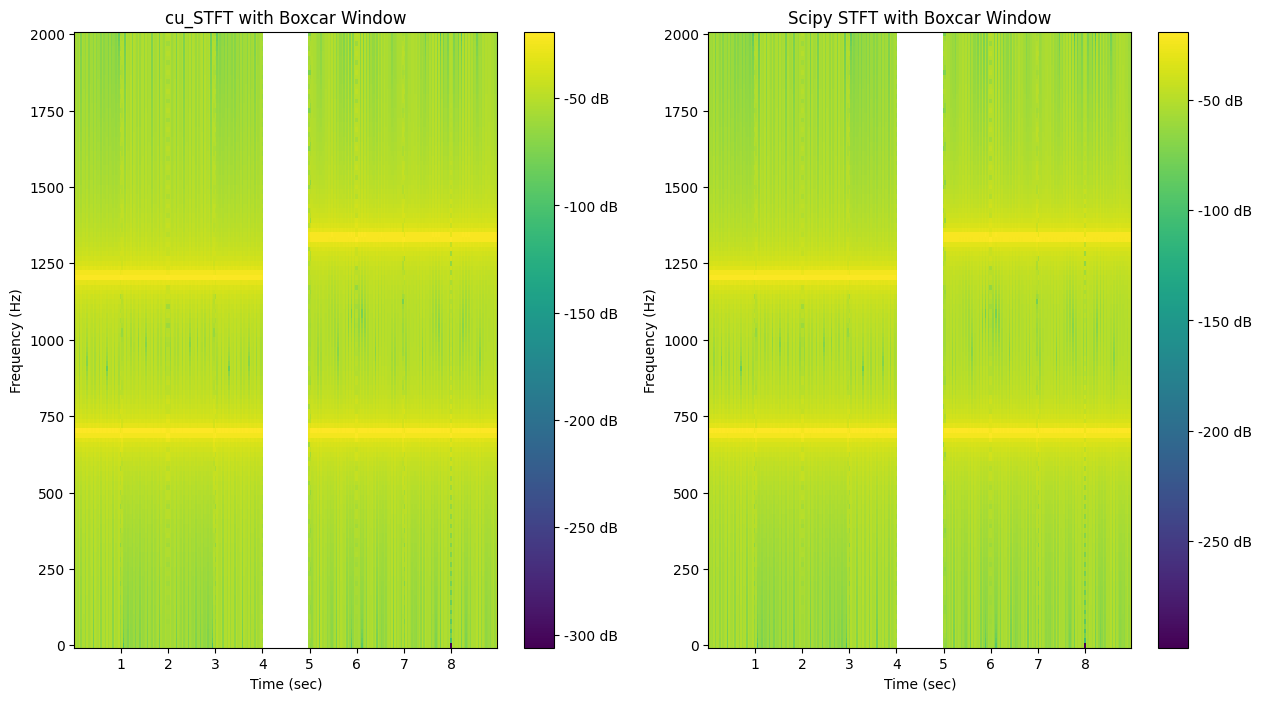

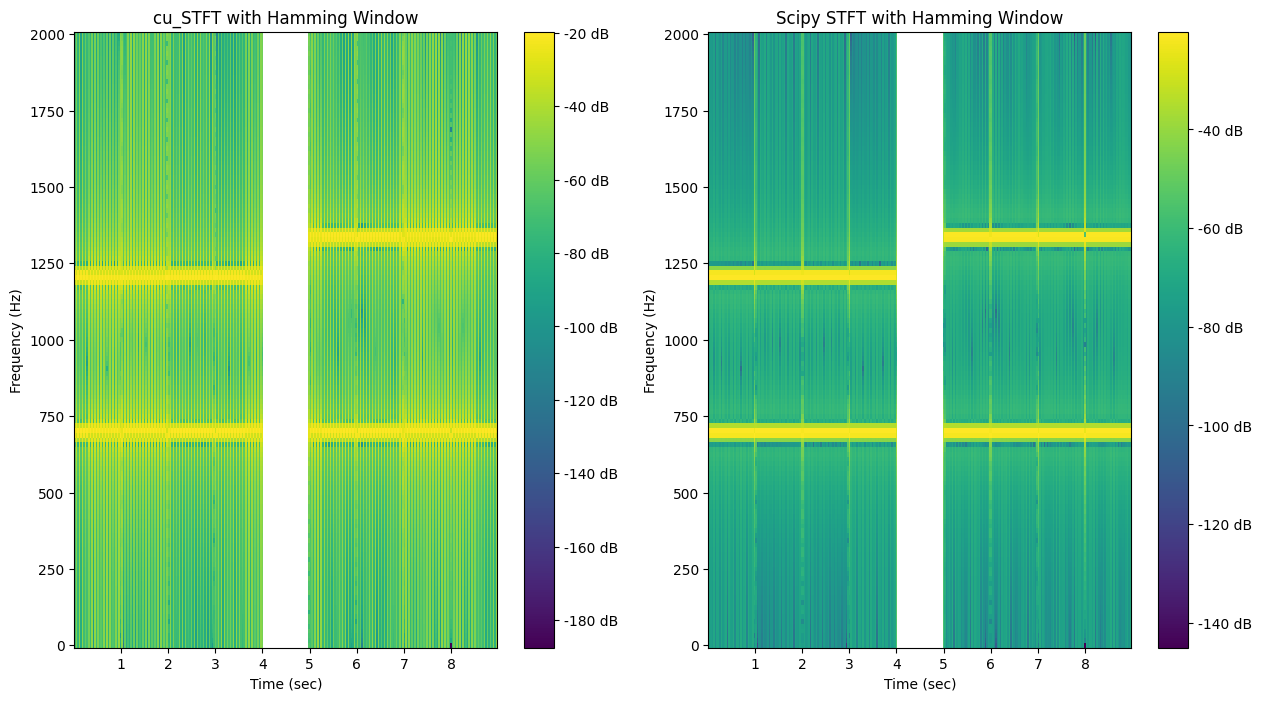

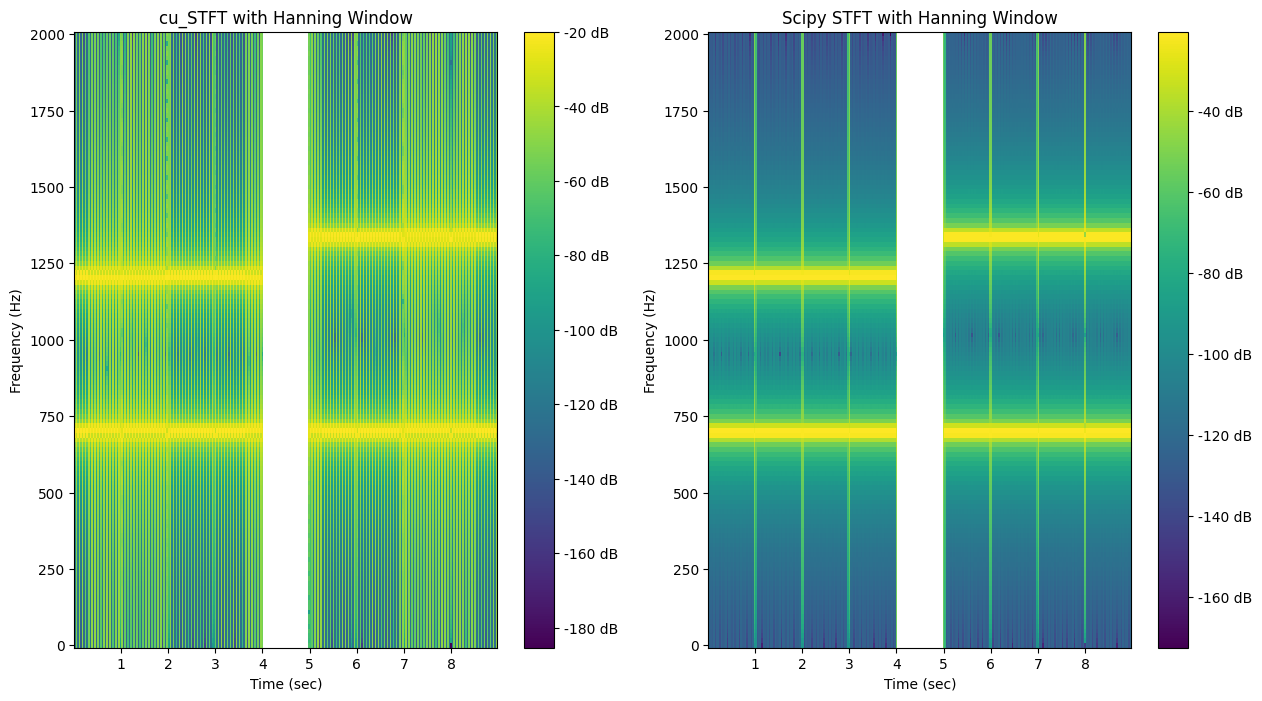

In [11]:
nfft = 256 
noverlap = -1
result = cu.cuSTFT(list(ts), sample_rate, nfft, noverlap, True, 0)
result_hamming = cu.cuSTFT(list(ts), sample_rate, nfft, noverlap, True, 1)
result_hanning = cu.cuSTFT(list(ts), sample_rate, nfft, noverlap, True, 2)

# mainly care about getting f and t for the graph right now
f, t, scipy_result_boxcar = scipy.signal.stft(ts, fs=sample_rate, window="boxcar", nperseg=nfft, noverlap=None if noverlap == -1 else noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
f, t, scipy_result_hamming = scipy.signal.stft(ts, fs=sample_rate, window="hamming", nperseg=nfft, noverlap=None if noverlap == -1 else noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
f, t, scipy_result_hanning = scipy.signal.stft(ts, fs=sample_rate, window="hann", nperseg=nfft, noverlap=None if noverlap == -1 else noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')

scipy_result_boxcar = np.abs(scipy_result_boxcar)
scipy_result_boxcar = 20*np.log10(scipy_result_boxcar)
scipy_result_hamming = np.abs(scipy_result_hamming)
scipy_result_hamming = 20*np.log10(scipy_result_hamming)
scipy_result_hanning = np.abs(scipy_result_hanning)
scipy_result_hanning = 20*np.log10(scipy_result_hanning)

# result = result[:,:-1] # my stft always takes one more time slice than scipy stft does
# result_hamming = result_hamming[:,:-1] # my stft always takes one more time slice than scipy stft does
# result_hanning = result_hanning[:,:-1] # my stft always takes one more time slice than scipy stft does

figsize = (15, 8)
plt.figure(figsize=figsize)
plt.subplot(121)
plt.title("cu_STFT with Boxcar Window")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, result)
plt.colorbar(format="%+2.f dB")

plt.subplot(122)
plt.title("Scipy STFT with Boxcar Window")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, scipy_result_boxcar)
plt.colorbar(format="%+2.f dB")
plt.show()

plt.figure(figsize=figsize)
plt.subplot(121)
plt.title("cu_STFT with Hamming Window")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, result_hamming)
plt.colorbar(format="%+2.f dB")

plt.subplot(122)
plt.title("Scipy STFT with Hamming Window")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, scipy_result_hamming)
plt.colorbar(format="%+2.f dB")
plt.show()

plt.figure(figsize=figsize)
plt.subplot(121)
plt.title("cu_STFT with Hanning Window")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, result_hanning)
plt.colorbar(format="%+2.f dB")

plt.subplot(122)
plt.title("Scipy STFT with Hanning Window")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(t, f, scipy_result_hanning)
plt.colorbar(format="%+2.f dB")
plt.show()

I have also added the ability to apply windows to the input samples. By default, the boxcar/rectangular window is not the best choice when conducting the stft. This is because the boxcar window creates a shorter bandwidth for the mainlobe, but has noticeable sidelobes. The main frequencies can still be found in the spectogram since they are the brightest green, but the spectogram overall is blurred with a lot of green. This is due to the sidelobes saturating much of the graph. 

On the other hand, the hamming and hanning windows are known as tapering windows. This is because they make the trade off of attenuating the sidelobes but resulting in a wider mainlobe. It is clear that the hanning window above is the best at not saturating the spectogram with a lot of sidelobe noise that could be confused as other signals. It also leaves the main frequencies present. 